plot profiles

In [1]:
# python modules
import sys
import copy
import re
import random
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
### parameters for plot profiles
domain_param = {}
for domain in ['TSS', 'TSS-TTS']:
    profile_len = 1000
    moving_average_win = 20
    pad_len = moving_average_win/2

    if domain == 'TSS':
        up_win = 2500
        down_win = 5000
        left_len = int(round(up_win*float(profile_len)/(up_win+down_win+1)))
        right_len = profile_len - left_len - 1
        offset = -left_len
        xtick_locs = [-left_len + pad_len, 0, right_len - pad_len]
        xtick_labels = ["-2.5kb", "TSS", "5kb"]


    elif domain == 'TSS-TTS':
        domain_frac = 0.6
        margin_frac = 1.0 - domain_frac
        up_win = 5000
        down_win = 2500
        left_len = int((margin_frac*profile_len)*(float(up_win)/(up_win + down_win)))
        right_len = int((margin_frac*profile_len)*(float(down_win)/(up_win + down_win)))
        offset = -left_len
        xtick_locs = [-left_len+pad_len,
                      0,
                      int(domain_frac*profile_len),
                      int(domain_frac*profile_len) + right_len - pad_len ]
        xtick_labels = ["-5kb", "TSS", "TTS", "2.5kb"]


    param = {}
    param['moving_average_win'] = moving_average_win
    param['profile_len'] = profile_len
    param['up_win'] = up_win
    param['down_win'] = down_win
    param['pad_len'] = pad_len
    param['left_len'] = left_len
    param['right_len'] = right_len
    param['offset'] = offset
    param['xtick_locs'] = xtick_locs
    param['xtick_labels'] = xtick_labels

    if domain == 'TSS-TTS':
        param['domain_frac'] = domain_frac
        param['margin_frac'] = margin_frac

    domain_param[domain] = param
    

In [7]:
### chromosome choices
#chr_choices = cell_chrnames['H1']
chr_choices = ['chr1']

In [8]:
### set plot parameters
param = domain_param['TSS-TTS']

In [9]:
### load profile files
gtab_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

dinfo_dkey = {'H1_NCP_HP1a_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz':
              {'H1_NCP_HP1a_3_1rep_deep':'Condensability',
              'ATcontent':'AT content',
              'H3K36me3':'H3K36me3',
              'CNumber(CpG)':'CNumber(CpG)',
              'meCNumber(CpG)':'meCNumber(CpG)'}
              }

dkey_geneID_profile = load_file.read_profile_batch (dinfo_dkey,
                                                    data_path=gtab_path)

loading H1_NCP_HP1a_1rep_deep_chr1_score_table_TSS-TTS_profile.txt.gz


Done


In [10]:
# compute methylation density
dkey_geneID_profile['meCpG density'] = statis.get_fract_profile(dkey_geneID_profile['meCNumber(CpG)'],
                                                                dkey_geneID_profile['CNumber(CpG)'])

del dkey_geneID_profile['meCNumber(CpG)']
del dkey_geneID_profile['CNumber(CpG)']

In [11]:
### read RNA-seq data
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/RNAseq/'
RNAseq_fname = 'ENCFF174OMR.tsv'
geneID_FPKM = load_file.read_ENCODE_RNA_seq(RNAseq_path + RNAseq_fname)

AT content


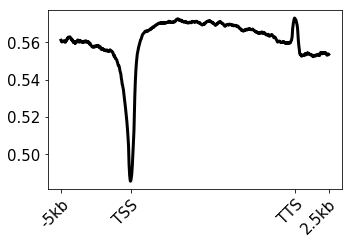

Condensability


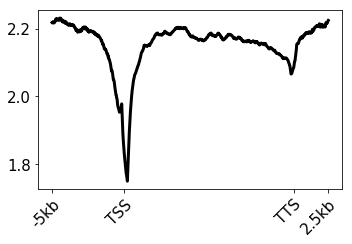

H3K36me3


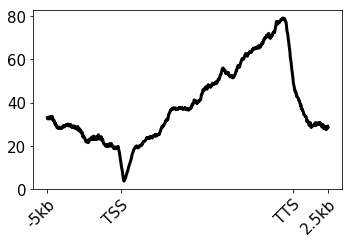

meCpG density


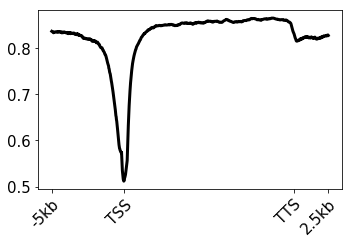

1

In [12]:
# plot mean profile
for dkey in sorted(dkey_geneID_profile):
    print dkey
    #geneID_profile = statis.NN_interpolate_dict(dkey_geneID_profile[dkey])
    geneID_profile = dkey_geneID_profile[dkey]
    mprofile = np.nanmean(geneID_profile.values(), axis=0)
    mprofile = statis.moving_average(mprofile, param['moving_average_win'])

    graphics.plot_profile (mprofile,
                           offset=param['offset'],
                           pad_len=param['pad_len'],
                           xtick_locs=param['xtick_locs'],
                           xtick_labels=param['xtick_labels'])
1                           

AT content


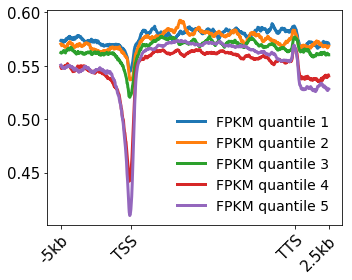

Condensability


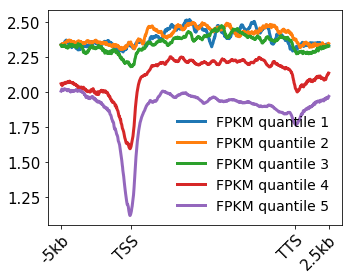

H3K36me3


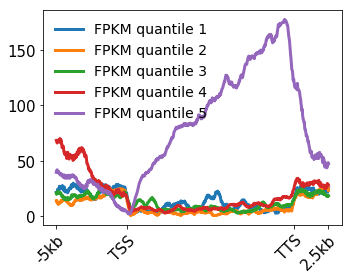

meCpG density


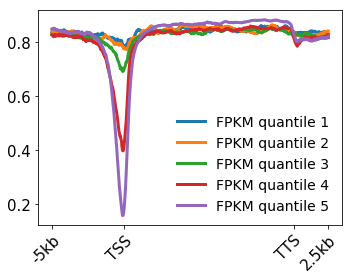

In [13]:
# partition quantiles according to gene expression level
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for dkey in sorted(dkey_geneID_profile):
    print dkey
    geneID_profile = dkey_geneID_profile[dkey]
    #geneID_profile = statis.NN_interpolate_dict(dkey_geneID_profile[dkey])
    geneIDs = set(geneID_profile.keys()) & set(geneID_FPKM.keys())
    q_geneIDs = statis.quantile_dict({geneID:geneID_FPKM[geneID] for geneID in geneIDs}, 5)

    profiles = []
    labels = []
    for i in range(len(q_geneIDs)):
        profile = np.nanmean([geneID_profile[geneID] for geneID in q_geneIDs[i]], axis=0)
        profile = statis.moving_average(profile, param['moving_average_win'])
        profiles.append(profile)
        labels.append('FPKM quantile %d' % (i+1))
        
    graphics.plot_profile_multiple (profiles,
                                    colors=colors,
                                    alphas=[1]*len(profiles),
                                    lws=[3]*len(profiles),
                                    labels=labels,
                                    offset=param['offset'],
                                    pad_len=param['pad_len'],
                                    xtick_locs=param['xtick_locs'],
                                    xtick_labels=param['xtick_labels'],
                                    note = '%s' % dkey,
                                    fig_width=5,
                                    fig_height=4)
        
    

H3K36me3


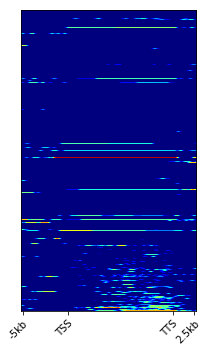

Condensability


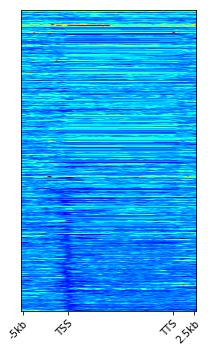

AT content


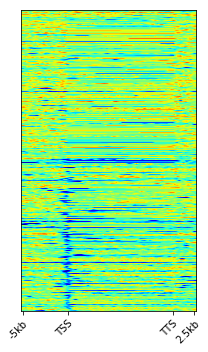

meCpG density


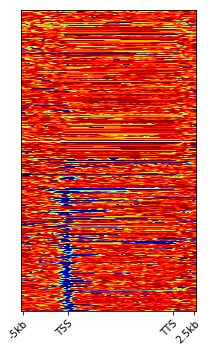

In [14]:
# plot profile heatmap
for dkey in dkey_geneID_profile:
    print dkey
    geneID_profile = dkey_geneID_profile[dkey]
    geneIDs = set(geneID_profile.keys()) & set(geneID_FPKM.keys())
    FPKM_geneID = sorted([(geneID_FPKM[geneID], geneID) for geneID in geneIDs])
    geneIDs = [geneID for FPKM, geneID in FPKM_geneID]
    profiles = []
    for geneID in geneIDs:
        profile = geneID_profile[geneID]
        profile = statis.moving_average(profile, param['moving_average_win'])
        profiles.append(profile)

    graphics.plot_profile_heatmap (profiles,
                                   offset=param['offset'],
                                   pad_len=param['pad_len'],
                                   xtick_locs=param['xtick_locs'],
                                   xtick_labels=param['xtick_labels'])

                          
